<a href="https://colab.research.google.com/github/Chtholly000/simplified-cnn-fer/blob/main/Model_1_JAFFE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


All libraries imported successfully.
Dataset found at: '/content/drive/MyDrive/Colab Notebooks/Intern (26 6-22 8)/jaffe'
Data preprocessing pipeline defined (without on-the-fly cropping for stability).
CNN Model 1 class is defined.
Using device: cuda

Successfully loaded JAFFE dataset.
Original training set size: 181
Augmented (20x) training set size: 3620
Validation set size: 32
Classes found and mapped.
Loss function: CrossEntropyLoss()

--- Starting Training for Model 1 on JAFFE ---
Epoch [001/100], Train Loss: 1.4907, Val Loss: 1.1782, Val Accuracy: 50.00%
Epoch [002/100], Train Loss: 0.4950, Val Loss: 0.8182, Val Accuracy: 81.25%
Epoch [003/100], Train Loss: 0.1758, Val Loss: 0.8683, Val Accuracy: 84.38%
Epoch [004/100], Train Loss: 0.1172, Val Loss: 0.9078, Val Accuracy: 84.38%
Epoch [005/100], Train Loss: 0.1181, Val Loss: 0.9024, Val Accuracy: 84.38%
Epoch [006/100], Train Loss: 0.0649, Val Loss: 1.7930, Val Accuracy: 65.62%
Epoch [007/100], Train Loss: 0.0791, Val Loss: 1.1553

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


--- Plotting Training History ---


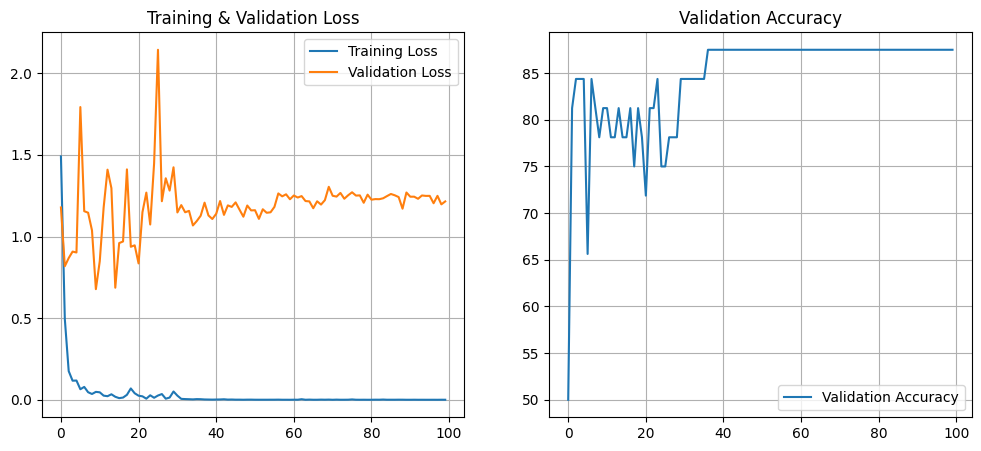


--- Visualizing Model Predictions ---


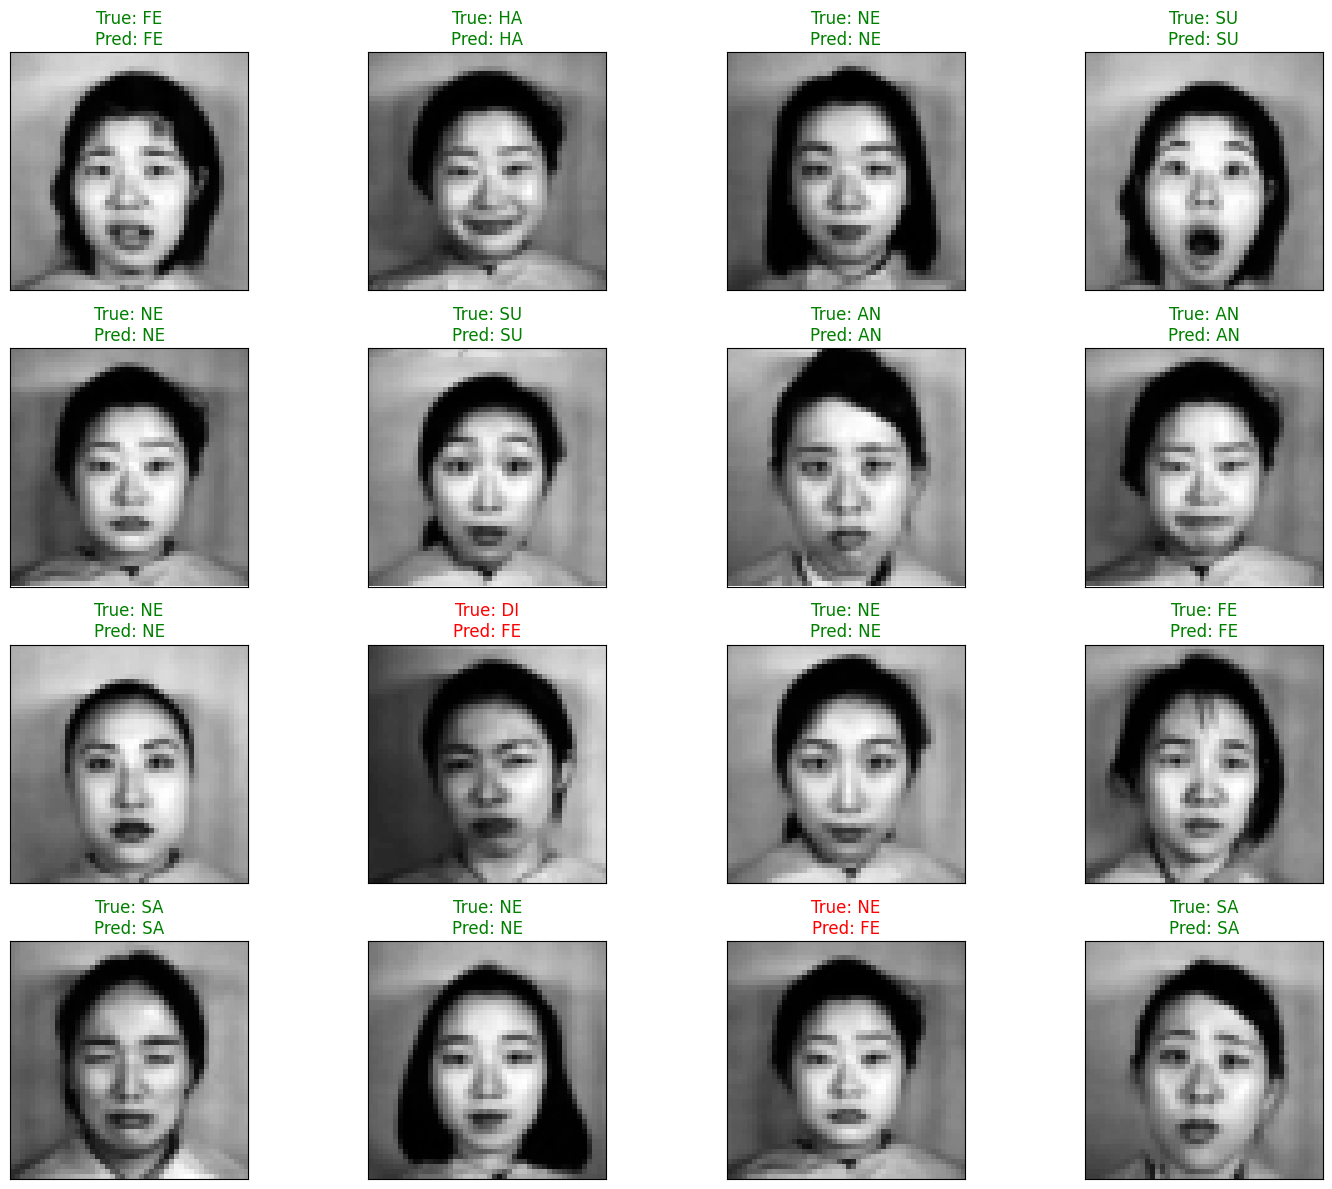

In [2]:
# ==============================================================================
# PART 1: IMPORTS AND SETUP
# ==============================================================================
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image
import requests
from google.colab import files
import re

print("All libraries imported successfully.")

# ==============================================================================
# PART 2: CONNECT TO GOOGLE DRIVE AND DEFINE DATA PATH
# ==============================================================================


# Step 2: Define the path to your JAFFE folder
# !!! IMPORTANT !!!
# Update the path below to point to the folder in your Google Drive
# that contains all the .tiff image files.
JAFFE_IMAGE_FOLDER_PATH = '/content/drive/MyDrive/Colab Notebooks/Intern (26 6-22 8)/jaffe'

if not os.path.exists(JAFFE_IMAGE_FOLDER_PATH):
    print(f"\n--- ERROR ---")
    print(f"The directory '{JAFFE_IMAGE_FOLDER_PATH}' was not found.")
    print("Please make sure you have uploaded the folder and the path is correct.")
    exit()
else:
    print(f"Dataset found at: '{JAFFE_IMAGE_FOLDER_PATH}'")


# ==============================================================================
# PART 3: DATA PREPROCESSING FOR JAFFE (FLAT FOLDER)
# ==============================================================================

class JaffeDatasetFromFolder(Dataset):
    """
    Custom PyTorch Dataset for the JAFFE dataset from a single 'flat' folder.
    It parses emotion labels from the filenames.
    """
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(root_dir) if f.lower().endswith(('.tiff', '.jpg', '.jpeg', '.png'))]
        self.emotion_labels = {'HA': 0, 'SA': 1, 'SU': 2, 'AN': 3, 'DI': 4, 'FE': 5, 'NE': 6}
        self.class_names = {v: k for k, v in self.emotion_labels.items()}

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_path).convert('L') # Convert to grayscale

        # Use regex to find the two-letter emotion code in the filename
        match = re.search(r'\.(.{2})\d', self.image_files[idx])
        if match:
            label_str = match.group(1).upper()
            label = self.emotion_labels.get(label_str, -1) # Use .get for safety
        else:
            label = -1 # Assign an invalid label if pattern not found

        if self.transform:
            image = self.transform(image)
        return image, label

# FIX: Base transform now only resizes and converts to tensor, removing the slow face-cropping step.
base_transform = transforms.Compose([
    transforms.Resize((48, 48)),  # Step c: Down-sample
    transforms.ToTensor()         # Step b: Normalize
])

# Augmentation transform for rotation
augmentation_transform = transforms.Compose([
    transforms.RandomRotation(degrees=5),
    transforms.RandomHorizontalFlip(p=0.5)
])

class AugmentedDataset(Dataset):
    """Multiplies dataset size by applying augmentations on-the-fly."""
    def __init__(self, base_dataset, augmentation_transform, factor=20):
        self.base_dataset = base_dataset
        self.augmentation_transform = augmentation_transform
        self.factor = factor
    def __len__(self):
        return len(self.base_dataset) * self.factor
    def __getitem__(self, idx):
        original_idx = idx % len(self.base_dataset)
        image, label = self.base_dataset[original_idx]
        # Important: Augmentation is applied to the already transformed tensor
        augmented_image = self.augmentation_transform(image)
        return augmented_image, label

print("Data preprocessing pipeline defined (without on-the-fly cropping for stability).")

# ==============================================================================
# PART 4: CNN MODEL 1 DEFINITION
# ==============================================================================
class CnnModel1(nn.Module):
    def __init__(self, num_classes=7):
        super(CnnModel1, self).__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5), nn.ReLU(), nn.BatchNorm2d(6), nn.MaxPool2d(2, 2),
            nn.Conv2d(6, 16, kernel_size=5), nn.ReLU(), nn.BatchNorm2d(16), nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 128, kernel_size=5), nn.ReLU(), nn.BatchNorm2d(128), nn.MaxPool2d(2, 2)
        )
        with torch.no_grad():
            dummy_output = self.feature_extractor(torch.zeros(1, 1, 48, 48))
            self.flattened_size = dummy_output.view(1, -1).size(1)
        self.classifier = nn.Sequential(
            nn.Linear(self.flattened_size, 256), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(256, 128), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )
    def forward(self, x):
        features = self.feature_extractor(x)
        logits = self.classifier(features.view(-1, self.flattened_size))
        return logits
print("CNN Model 1 class is defined.")

# ==============================================================================
# PART 5: TRAINING SCRIPT FOR MODEL 1 ON JAFFE
# ==============================================================================
# --- Configuration ---
NUM_EPOCHS = 100
BATCH_SIZE = 64
LEARNING_RATE = 0.001

# --- Set Device to GPU ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- Load the JAFFE Data ---
try:
    base_jaffe_dataset = JaffeDatasetFromFolder(root_dir=JAFFE_IMAGE_FOLDER_PATH, transform=base_transform)

    # Split the original dataset into training and validation sets (85% / 15% as per paper)
    train_size_orig = int(0.85 * len(base_jaffe_dataset))
    val_size_orig = len(base_jaffe_dataset) - train_size_orig
    train_dataset_orig, val_dataset = torch.utils.data.random_split(base_jaffe_dataset, [train_size_orig, val_size_orig])

    # Create the augmented dataset with a 20x factor
    augmented_train_dataset = AugmentedDataset(
        base_dataset=train_dataset_orig,
        augmentation_transform=augmentation_transform,
        factor=20  # Reduced factor for faster, more workable training
    )

    # Set num_workers=0 to prevent hanging issues in Colab
    train_loader = DataLoader(augmented_train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

    print(f"\nSuccessfully loaded JAFFE dataset.")
    print(f"Original training set size: {len(train_dataset_orig)}")
    print(f"Augmented (20x) training set size: {len(augmented_train_dataset)}")
    print(f"Validation set size: {len(val_dataset)}")
    class_names = base_jaffe_dataset.class_names
    print(f"Classes found and mapped.")
except Exception as e:
    print(f"\n--- ERROR LOADING DATA ---")
    print(f"Could not load the dataset. Error: {e}")
    exit()

# --- Instantiate Model, Loss, and Optimizer ---
model = CnnModel1(num_classes=len(class_names))
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
print(f"Loss function: {criterion}")

# --- The Training Loop ---
history = {'train_loss': [], 'val_loss': [], 'val_accuracy': []}
print("\n--- Starting Training for Model 1 on JAFFE ---")
for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_loss = running_loss / len(train_loader)
    history['train_loss'].append(epoch_loss)

    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_accuracy = 100 * correct / total
    avg_val_loss = val_loss / len(val_loader) if len(val_loader) > 0 else 0
    history['val_loss'].append(avg_val_loss)
    history['val_accuracy'].append(val_accuracy)
    scheduler.step()
    print(f"Epoch [{epoch+1:03d}/{NUM_EPOCHS}], Train Loss: {epoch_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")
print("--- Finished Training ---")

# ==============================================================================
# PART 6: SAVE, DOWNLOAD, AND VISUALIZE RESULTS
# ==============================================================================
MODEL_SAVE_PATH = 'jaffe_model_1.pth'
print(f"\nSaving model to {MODEL_SAVE_PATH}...")
torch.save(model.state_dict(), MODEL_SAVE_PATH)
print("Model saved successfully.")
files.download(MODEL_SAVE_PATH)

print("\n--- Plotting Training History ---")
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Training Loss'); plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training & Validation Loss'); plt.legend(); plt.grid(True)
plt.subplot(1, 2, 2)
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Validation Accuracy'); plt.legend(); plt.grid(True)
plt.show()

print("\n--- Visualizing Model Predictions ---")
loaded_model = CnnModel1(num_classes=len(class_names))
loaded_model.load_state_dict(torch.load(MODEL_SAVE_PATH))
loaded_model.to(device)
loaded_model.eval()
images, labels = next(iter(val_loader))
images, labels = images.to(device), labels.to(device)
with torch.no_grad():
    outputs = loaded_model(images)
    _, predicted = torch.max(outputs, 1)
images, labels, predicted = images.cpu(), labels.cpu(), predicted.cpu()
fig = plt.figure(figsize=(15, 12))
for i in range(min(len(images), 16)):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(images[i].squeeze(), cmap='gray')
    true_label = class_names[labels[i].item()]
    pred_label = class_names[predicted[i].item()]
    title_color = 'g' if true_label == pred_label else 'r'
    ax.set_title(f"True: {true_label}\nPred: {pred_label}", color=title_color)
plt.tight_layout()
plt.show()


